## Evolutionary Algorithm - Travelling Salesman Problem

### Import relevant libraries

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import random
import pandas as pd
from evoAlg_operators  import evoALg_edgecross, evoALg_singlecross
import experiment_design
from collections import Counter
import matplotlib.pyplot as plt
import time
import progressbar
import cProfile
import scipy.stats as stats
import seaborn as sns

plt.style.use('seaborn-v0_8-dark-palette')

%matplotlib inline

### Import Data for Brazil and Burma
The data will be encoded using k-array encoding with k equal to the number of cities and each array also having a length L=k.

In [2]:
def XMLreader(file_name):
      '''Reads the XML file in current directory and returns a numpy.ndarray a 
      square cost_matrix with nrow and ncol equal to the number of cities in the data'''
      # open the XML file
      tree = ET.parse(file_name)
      root = tree.getroot()

      # extract the vertex data
      vertices = root.findall('.//vertex')

      # initialize an empty matrix to store the costs
      num_cities = len(vertices)
      cost_matrix = np.zeros((num_cities, num_cities))

      # populate the cost matrix
      for i, vertex in enumerate(vertices):
            edges = vertex.findall('edge')
            for edge in edges:
                  j = int(edge.text) # Get the city name (an integer)
                  cost = float(edge.get('cost'))
                  cost_matrix[i][j] = cost
      
      return cost_matrix

In [3]:
cost_matrix_Brazil = XMLreader("brazil58.xml")
cost_matrix_Burma = XMLreader('burma14.xml')

In [4]:
cost_matrix_Brazil

array([[   0., 2635., 2713., ..., 3870., 1417.,  739.],
       [2635.,    0.,  314., ..., 2072., 1196., 1517.],
       [2713.,  314.,    0., ..., 1882., 2699., 1557.],
       ...,
       [3870., 2072., 1882., ...,    0., 2328., 2986.],
       [1417., 1196., 2699., ..., 2328.,    0.,  962.],
       [ 739., 1517., 1557., ..., 2986.,  962.,    0.]])

In [5]:
cost_matrix_Brazil.shape

(58, 58)

In [6]:
cost_matrix_Burma

array([[   0.,  153.,  510.,  706.,  966.,  581.,  455.,   70.,  160.,
         372.,  157.,  567.,  342.,  398.],
       [ 153.,    0.,  422.,  664.,  997.,  598.,  507.,  197.,  311.,
         479.,  310.,  581.,  417.,  376.],
       [ 510.,  422.,    0.,  289.,  744.,  390.,  437.,  491.,  645.,
         880.,  618.,  374.,  455.,  211.],
       [ 706.,  664.,  289.,    0.,  491.,  265.,  410.,  664.,  804.,
        1070.,  768.,  259.,  499.,  310.],
       [ 966.,  997.,  744.,  491.,    0.,  400.,  514.,  902.,  990.,
        1261.,  947.,  418.,  635.,  636.],
       [ 581.,  598.,  390.,  265.,  400.,    0.,  168.,  522.,  634.,
         910.,  593.,   19.,  284.,  239.],
       [ 455.,  507.,  437.,  410.,  514.,  168.,    0.,  389.,  482.,
         757.,  439.,  163.,  124.,  232.],
       [  70.,  197.,  491.,  664.,  902.,  522.,  389.,    0.,  154.,
         406.,  133.,  508.,  273.,  355.],
       [ 160.,  311.,  645.,  804.,  990.,  634.,  482.,  154.,    0.,
         

In [7]:
cost_matrix_Burma.shape

(14, 14)

### Implementation and Experimentation
Here are the different parameters/operators that will be used in this experiment

* Crossover operator: Single Point crossover, Edge crossover
* Mutation operator: Single swap mutation, Insert mutation, Inversion mutation and Scramble mutation
* Parent selection operator: Tournament Selection
* Replacement operator: Replace weakest, Replace 1st weakest,
* Population size: 50, 100, 200
* Tournament size: 5, 10, 20
* Crossover rate: 1
* Mutation rate: 1

#### Methodology
For each experiment we will run it N=10 times each with 10 random seeds. 

In [8]:
np.random.seed(1)
np.random.choice(np.arange(999), 10)

array([ 37, 235, 908,  72, 767, 905, 715, 645, 847, 960])

In [9]:
pop_size = [50, 100, 200]
tourn_size = [5, 10, 20]
seed = [37, 235, 908,  72, 767, 905, 715, 645, 847, 960]

**Note** that, as stated in the README files, the bulk_experiment function performs about 144 experiments for 10 random trials and this takes time. It was done so that I could analyze the effect of each combination of parameters and operators. What I've done is to upload the data derived on Google drive. As you continue with this notebook (Importing and Preprocessing data section), it'll automatically download it.

In [10]:
'''
def bulk_experiment(cost_matrix, pop_size, tourn_size, seed):
      experiment_dfs = pd.DataFrame()
      best_results = pd.DataFrame()

      for pop in pop_size:
            for tourn in tourn_size:
                  # experiment design involving single point crossover
                  all_res, best_res = experiment_design.singleCRSV(pop, tourn, cost_matrix, seed)

                  # add population size and tourn size columns to data
                  all_res['pop_size'] = pop
                  all_res['tourn_size'] = tourn
                  best_res['pop_size'] = pop
                  best_res['tourn_size'] = tourn

                  # concat data to df
                  experiment_dfs = pd.concat([experiment_dfs, all_res], ignore_index=True)
                  best_results = pd.concat([best_results, best_res], ignore_index=True)
                  print('-'*79)

                  # experiment design involving single point crossover
                  all_res, best_res = experiment_design.edgeCRSV(pop, tourn, cost_matrix, seed)

                  # add population size and tourn size columns to data
                  all_res['pop_size'] = pop
                  all_res['tourn_size'] = tourn
                  best_res['pop_size'] = pop
                  best_res['tourn_size'] = tourn

                  # concat data to df
                  experiment_dfs = pd.concat([experiment_dfs, all_res], ignore_index=True)
                  best_results = pd.concat([best_results, best_res], ignore_index=True)
                  print('-'*79)

      return experiment_dfs, best_results
'''

"\ndef bulk_experiment(cost_matrix, pop_size, tourn_size, seed):\n      experiment_dfs = pd.DataFrame()\n      best_results = pd.DataFrame()\n\n      for pop in pop_size:\n            for tourn in tourn_size:\n                  # experiment design involving single point crossover\n                  all_res, best_res = experiment_design.singleCRSV(pop, tourn, cost_matrix, seed)\n\n                  # add population size and tourn size columns to data\n                  all_res['pop_size'] = pop\n                  all_res['tourn_size'] = tourn\n                  best_res['pop_size'] = pop\n                  best_res['tourn_size'] = tourn\n\n                  # concat data to df\n                  experiment_dfs = pd.concat([experiment_dfs, all_res], ignore_index=True)\n                  best_results = pd.concat([best_results, best_res], ignore_index=True)\n                  print('-'*79)\n\n                  # experiment design involving single point crossover\n                  all_res,

Running the experiment for Brazil

In [11]:
#experiment_dfs_BRAZIL, best_results_BRAZIL = bulk_experiment(cost_matrix_Brazil, pop_size, tourn_size, seed)

Running the experiment for Burma

In [12]:
#experiment_dfs_BURMA, best_results_BURMA = bulk_experiment(cost_matrix_Burma, pop_size, tourn_size, seed)

In [13]:
'''experiment_dfs_BRAZIL.to_csv("experiment_dfs_BRAZIL.csv", encoding='utf-8',index=False,sep='\t')
best_results_BRAZIL['solution_list'] = [list(sol) for sol in best_results_BRAZIL['solution']]
best_results_BRAZIL.to_csv("best_results_BRAZIL.csv", encoding='utf-8',index=False,sep='\t')

experiment_dfs_BURMA.to_csv("experiment_dfs_BURMA.csv", encoding='utf-8', index=False,sep='\t')
best_results_BURMA['solution_list'] = [list(sol) for sol in best_results_BURMA['solution']]
best_results_BURMA.to_csv("best_results_BURMA.csv", encoding='utf-8', index=False,sep='\t')'''

'experiment_dfs_BRAZIL.to_csv("experiment_dfs_BRAZIL.csv", encoding=\'utf-8\',index=False,sep=\'\t\')\nbest_results_BRAZIL[\'solution_list\'] = [list(sol) for sol in best_results_BRAZIL[\'solution\']]\nbest_results_BRAZIL.to_csv("best_results_BRAZIL.csv", encoding=\'utf-8\',index=False,sep=\'\t\')\n\nexperiment_dfs_BURMA.to_csv("experiment_dfs_BURMA.csv", encoding=\'utf-8\', index=False,sep=\'\t\')\nbest_results_BURMA[\'solution_list\'] = [list(sol) for sol in best_results_BURMA[\'solution\']]\nbest_results_BURMA.to_csv("best_results_BURMA.csv", encoding=\'utf-8\', index=False,sep=\'\t\')'

#### Importing and Preprocessing Data
As was stated in the README file, the `bulk_experiment` function takes a lot of time to run since for each seed (10 trials), it generates data for all the possible parameter/operator combinations. What I've done is to upload the data on my Google Drive, so that you could also view it, and then read it from there.

The following cells below download the folder which contains the files from Google drive and saves it in this directory.

In [14]:
# for downloading large files from Google drive
!pip install gdown

In [15]:
!gdown --folder https://drive.google.com/drive/folders/1zwycioJrXLKt8Qxk2PQpQqNA4hKmnxda?usp=sharing

Processing file 1wZ-uEcruqRUZuQ9rO3Ve_hEd9kNtw21L best_results_BRAZIL.csv
Processing file 1vmT4lb0BycK_rKMc0VBCgGO26BQ6Vu01 best_results_BURMA.csv
Processing file 1FB4KcB-Po13irB7jmtSxBmuNbbbP-odQ experiment_dfs_BRAZIL.csv
Processing file 12txzMCLApP9ZNF7PEmiGyoA-cAoQqEpp experiment_dfs_BURMA.csv
Building directory structure completed


Retrieving folder list
Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1wZ-uEcruqRUZuQ9rO3Ve_hEd9kNtw21L
To: c:\Users\LEGION\Documents\Msc Data Science - Uni of Exeter\ECMM409 - Nature-Inspired Computation (2023)\Coursework\ECMM409 CW Dataset\best_results_BRAZIL.csv

  0%|          | 0.00/673k [00:00<?, ?B/s]
100%|██████████| 673k/673k [00:00<00:00, 10.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vmT4lb0BycK_rKMc0VBCgGO26BQ6Vu01
To: c:\Users\LEGION\Documents\Msc Data Science - Uni of Exeter\ECMM409 - Nature-Inspired Computation (2023)\Coursework\ECMM409 CW Dataset\best_results_BURMA.csv

  0%|          | 0.00/222k [00:00<?, ?B/s]
100%|██████████| 222k/222k [00:00<00:00, 2.81MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1FB4KcB-Po13irB7jmtSxBmuNbbbP-odQ
From (redirected): https://drive.google.com/uc?id=1FB4KcB-Po13irB7jmtSxBmuNbbbP-odQ&confirm=t&uuid=0815d785-63f3-4fb3-8950-33d6b5f376

In [16]:
experiment_dfs_BRAZIL = pd.read_csv('./ECMM409 CW Dataset/experiment_dfs_BRAZIL.csv',sep='\t')
best_results_BRAZIL = pd.read_csv('./ECMM409 CW Dataset/best_results_BRAZIL.csv',sep='\t')
best_results_BRAZIL['solution_list'] = pd.Series([np.array(sol.replace('[','').replace(']','').split(', '), dtype=np.int64) for sol in best_results_BRAZIL['solution_list']])

experiment_dfs_BURMA = pd.read_csv('./ECMM409 CW Dataset/experiment_dfs_BURMA.csv',sep='\t')
best_results_BURMA = pd.read_csv('./ECMM409 CW Dataset/best_results_BURMA.csv',sep='\t')
best_results_BURMA['solution_list'] = pd.Series([np.array(sol.replace('[','').replace(']','').split(', '), dtype=np.int64) for sol in best_results_BURMA['solution_list']])

In [17]:
experiment_dfs_BRAZIL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440000 entries, 0 to 1439999
Data columns (total 16 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   iteration   1440000 non-null  int64  
 1   mut_func    1440000 non-null  object 
 2   repl_func   1440000 non-null  object 
 3   37          1440000 non-null  float64
 4   235         1440000 non-null  float64
 5   908         1440000 non-null  float64
 6   72          1440000 non-null  float64
 7   767         1440000 non-null  float64
 8   905         1440000 non-null  float64
 9   715         1440000 non-null  float64
 10  645         1440000 non-null  float64
 11  847         1440000 non-null  float64
 12  960         1440000 non-null  float64
 13  crsv_type   1440000 non-null  object 
 14  pop_size    1440000 non-null  int64  
 15  tourn_size  1440000 non-null  int64  
dtypes: float64(10), int64(3), object(3)
memory usage: 175.8+ MB


In [18]:
experiment_dfs_BURMA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440000 entries, 0 to 1439999
Data columns (total 16 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   iteration   1440000 non-null  int64  
 1   mut_func    1440000 non-null  object 
 2   repl_func   1440000 non-null  object 
 3   37          1440000 non-null  float64
 4   235         1440000 non-null  float64
 5   908         1440000 non-null  float64
 6   72          1440000 non-null  float64
 7   767         1440000 non-null  float64
 8   905         1440000 non-null  float64
 9   715         1440000 non-null  float64
 10  645         1440000 non-null  float64
 11  847         1440000 non-null  float64
 12  960         1440000 non-null  float64
 13  crsv_type   1440000 non-null  object 
 14  pop_size    1440000 non-null  int64  
 15  tourn_size  1440000 non-null  int64  
dtypes: float64(10), int64(3), object(3)
memory usage: 175.8+ MB


In [19]:
best_results_BRAZIL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seed           1440 non-null   int64  
 1   mut_type       1440 non-null   object 
 2   repl_type      1440 non-null   object 
 3   solution       1440 non-null   object 
 4   fitness        1440 non-null   float64
 5   exec_time      1440 non-null   float64
 6   crsv_type      1440 non-null   object 
 7   pop_size       1440 non-null   int64  
 8   tourn_size     1440 non-null   int64  
 9   solution_list  1440 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 112.6+ KB


In [20]:
best_results_BURMA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seed           1440 non-null   int64  
 1   mut_type       1440 non-null   object 
 2   repl_type      1440 non-null   object 
 3   solution       1440 non-null   object 
 4   fitness        1440 non-null   float64
 5   exec_time      1440 non-null   float64
 6   crsv_type      1440 non-null   object 
 7   pop_size       1440 non-null   int64  
 8   tourn_size     1440 non-null   int64  
 9   solution_list  1440 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 112.6+ KB


Working on Brazil now

`experiment_dfs_BRAZIL`:
This data will be what I use to plot convergence curves based on the parameter combinations that I'll choose from the other dataset.
* Find the mean of all the fitness/iteration for each seed.
* Find the sample standard deviation
* Find the sample error of the mean
* Get 95% confidence interval
* save to new df

In [21]:
experiment_dfs_BRAZIL

,iteration,mut_func,repl_func,37,235,908,72,767,905,715,645,847,960,crsv_type,pop_size,tourn_size
0,0,swap,1st Weakest,109228.0,107228.0,109490.0,107280.0,110884.0,100560.0,104388.0,108282.0,111417.0,109799.0,Single Point,50,5
1,1,swap,1st Weakest,109228.0,100402.0,109490.0,107280.0,110884.0,100560.0,104388.0,108282.0,111417.0,109799.0,Single Point,50,5
2,2,swap,1st Weakest,109228.0,100402.0,109490.0,107280.0,110884.0,100560.0,104388.0,108282.0,111417.0,109799.0,Single Point,50,5
3,3,swap,1st Weakest,109228.0,100402.0,109490.0,107280.0,110884.0,100560.0,104388.0,108282.0,111417.0,107016.0,Single Point,50,5
4,4,swap,1st Weakest,109228.0,100402.0,109490.0,107280.0,110884.0,100560.0,104388.0,108282.0,111417.0,107016.0,Single Point,50,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439995,9995,scramble,Weakest,36015.0,30789.0,29926.0,35216.0,30534.0,34594.0,35205.0,33926.0,35356.0,33321.0,Edge,200,20
1439996,9996,scramble,Weakest,36015.0,30789.0,29926.0,35216.0,30534.0,34594.0,35205.0,33926.0,35356.0,33321.0,Edge,200,20
1439997,9997,scramble,Weakest,36015.0,30789.0,29926.0,35216.0,30534.0,34594.0,35205.0,33926.0,35356.0,33321.0,Edge,200,20
1439998,9998,scramble,Weakest,36015.0,30789.0,29926.0,35216.0,30534.0,34594.0,35205.0,33926.0,35356.0,33321.0,Edge,200,20


In [22]:
# mean best fitness across all trials
experiment_dfs_BRAZIL['Mean Best Fitness'] = experiment_dfs_BRAZIL.iloc[:,3:13].mean(axis=1)
experiment_dfs_BRAZIL['Mean Log(Best Fitness)'] = np.log10(experiment_dfs_BRAZIL.iloc[:,3:13]).mean(axis=1)
# standard deviation for the fitness
experiment_dfs_BRAZIL['Sample SD'] = experiment_dfs_BRAZIL.iloc[:,3:13].std(axis=1,ddof=1)

# let's find the 95% confidence interval for each fitness value
# Calculate the t-value for a 95% confidence interval
t_value = stats.t.ppf(0.975, 10-1)  # 0.975 corresponds to (1 - alpha/2), (10-1) represents the ddof
# calculate the margin of error
marg_err = (t_value * experiment_dfs_BRAZIL['Sample SD'])/ np.sqrt(10)   # 10 refers to the sample size
# Calculate the lower and upper bounds of the confidence interval   
experiment_dfs_BRAZIL['ci_low'] = experiment_dfs_BRAZIL['Mean Best Fitness'] - marg_err 
experiment_dfs_BRAZIL['ci_high'] = experiment_dfs_BRAZIL['Mean Best Fitness'] + marg_err 

experiment_dfs_BRAZIL['Mean Best Fitness'] = experiment_dfs_BRAZIL['Mean Best Fitness'].round(2)
experiment_dfs_BRAZIL['Sample SD'] = experiment_dfs_BRAZIL['Sample SD'].round(2)
experiment_dfs_BRAZIL['ci_low'] = experiment_dfs_BRAZIL['ci_low'].round(2)
experiment_dfs_BRAZIL['ci_high'] = experiment_dfs_BRAZIL['ci_high'].round(2)

In [23]:
experiment_dfs_BRAZIL

,iteration,mut_func,repl_func,37,235,908,72,767,905,715,...,847,960,crsv_type,pop_size,tourn_size,Mean Best Fitness,Mean Log(Best Fitness),Sample SD,ci_low,ci_high
0,0,swap,1st Weakest,109228.0,107228.0,109490.0,107280.0,110884.0,100560.0,104388.0,...,111417.0,109799.0,Single Point,50,5,107855.6,5.032659,3271.82,105515.08,110196.12
1,1,swap,1st Weakest,109228.0,100402.0,109490.0,107280.0,110884.0,100560.0,104388.0,...,111417.0,109799.0,Single Point,50,5,107173.0,5.029802,4039.34,104283.43,110062.57
2,2,swap,1st Weakest,109228.0,100402.0,109490.0,107280.0,110884.0,100560.0,104388.0,...,111417.0,109799.0,Single Point,50,5,107173.0,5.029802,4039.34,104283.43,110062.57
3,3,swap,1st Weakest,109228.0,100402.0,109490.0,107280.0,110884.0,100560.0,104388.0,...,111417.0,107016.0,Single Point,50,5,106894.7,5.028687,3932.78,104081.36,109708.04
4,4,swap,1st Weakest,109228.0,100402.0,109490.0,107280.0,110884.0,100560.0,104388.0,...,111417.0,107016.0,Single Point,50,5,106894.7,5.028687,3932.78,104081.36,109708.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439995,9995,scramble,Weakest,36015.0,30789.0,29926.0,35216.0,30534.0,34594.0,35205.0,...,35356.0,33321.0,Edge,200,20,33488.2,4.523977,2259.57,31871.80,35104.60
1439996,9996,scramble,Weakest,36015.0,30789.0,29926.0,35216.0,30534.0,34594.0,35205.0,...,35356.0,33321.0,Edge,200,20,33488.2,4.523977,2259.57,31871.80,35104.60
1439997,9997,scramble,Weakest,36015.0,30789.0,29926.0,35216.0,30534.0,34594.0,35205.0,...,35356.0,33321.0,Edge,200,20,33488.2,4.523977,2259.57,31871.80,35104.60
1439998,9998,scramble,Weakest,36015.0,30789.0,29926.0,35216.0,30534.0,34594.0,35205.0,...,35356.0,33321.0,Edge,200,20,33488.2,4.523977,2259.57,31871.80,35104.60


In [24]:
experiment_dfs_BRAZIL.columns

Index(['iteration', 'mut_func', 'repl_func', '37', '235', '908', '72', '767',
       '905', '715', '645', '847', '960', 'crsv_type', 'pop_size',
       'tourn_size', 'Mean Best Fitness', 'Mean Log(Best Fitness)',
       'Sample SD', 'ci_low', 'ci_high'],
      dtype='object')

In [25]:
brazil_fit_iter = experiment_dfs_BRAZIL[['iteration', 'crsv_type', 'pop_size', 'tourn_size', 'mut_func', 
                                         'repl_func', 'Mean Best Fitness', 'Sample SD', 'ci_low', 'ci_high', 'Mean Log(Best Fitness)']].copy()

In [26]:
brazil_fit_iter

,iteration,crsv_type,pop_size,tourn_size,mut_func,repl_func,Mean Best Fitness,Sample SD,ci_low,ci_high,Mean Log(Best Fitness)
0,0,Single Point,50,5,swap,1st Weakest,107855.6,3271.82,105515.08,110196.12,5.032659
1,1,Single Point,50,5,swap,1st Weakest,107173.0,4039.34,104283.43,110062.57,5.029802
2,2,Single Point,50,5,swap,1st Weakest,107173.0,4039.34,104283.43,110062.57,5.029802
3,3,Single Point,50,5,swap,1st Weakest,106894.7,3932.78,104081.36,109708.04,5.028687
4,4,Single Point,50,5,swap,1st Weakest,106894.7,3932.78,104081.36,109708.04,5.028687
...,...,...,...,...,...,...,...,...,...,...,...
1439995,9995,Edge,200,20,scramble,Weakest,33488.2,2259.57,31871.80,35104.60,4.523977
1439996,9996,Edge,200,20,scramble,Weakest,33488.2,2259.57,31871.80,35104.60,4.523977
1439997,9997,Edge,200,20,scramble,Weakest,33488.2,2259.57,31871.80,35104.60,4.523977
1439998,9998,Edge,200,20,scramble,Weakest,33488.2,2259.57,31871.80,35104.60,4.523977


In [27]:
del_pops = [500, 1000]
drop_pop_vals = brazil_fit_iter.query("pop_size in @del_pops").index
brazil_fit_iter = brazil_fit_iter.drop(index=drop_pop_vals)

In [28]:
brazil_fit_iter.rename(columns={'mut_func':'mut_type', 'repl_func':'repl_type'}, inplace=True)

In [29]:
best_results_BRAZIL

,seed,mut_type,repl_type,solution,fitness,exec_time,crsv_type,pop_size,tourn_size,solution_list
0,37,swap,1st Weakest,[38 15 10 55 45 18 25 7 3 49 29 0 12 8 19 ...,53482.0,3.694767,Single Point,50,5,"[38, 15, 10, 55, 45, 18, 25, 7, 3, 49, 29, 0, ..."
1,37,swap,Weakest,[ 3 31 8 39 12 29 0 11 48 35 20 41 6 30 37 ...,47730.0,3.678923,Single Point,50,5,"[3, 31, 8, 39, 12, 29, 0, 11, 48, 35, 20, 41, ..."
2,37,insert,1st Weakest,[28 40 8 39 57 16 25 9 2 54 7 48 33 14 36 ...,85619.0,3.122258,Single Point,50,5,"[28, 40, 8, 39, 57, 16, 25, 9, 2, 54, 7, 48, 3..."
3,37,insert,Weakest,[24 52 49 39 56 11 34 41 31 38 28 1 48 57 8 ...,95316.0,3.131077,Single Point,50,5,"[24, 52, 49, 39, 56, 11, 34, 41, 31, 38, 28, 1..."
4,37,inversion,1st Weakest,[49 53 26 33 34 48 40 52 8 39 17 22 2 25 44 ...,89374.0,2.894494,Single Point,50,5,"[49, 53, 26, 33, 34, 48, 40, 52, 8, 39, 17, 22..."
...,...,...,...,...,...,...,...,...,...,...
1435,960,insert,Weakest,[44 55 45 33 14 36 13 27 5 18 25 16 35 20 2 ...,27215.0,33.130703,Edge,200,20,"[44, 55, 45, 33, 14, 36, 13, 27, 5, 18, 25, 16..."
1436,960,inversion,1st Weakest,[21 7 3 49 52 19 31 24 39 8 12 29 0 17 43 ...,26279.0,33.290278,Edge,200,20,"[21, 7, 3, 49, 52, 19, 31, 24, 39, 8, 12, 29, ..."
1437,960,inversion,Weakest,[52 49 3 7 21 15 37 41 6 30 10 38 20 35 16 ...,25435.0,33.085484,Edge,200,20,"[52, 49, 3, 7, 21, 15, 37, 41, 6, 30, 10, 38, ..."
1438,960,scramble,1st Weakest,[40 1 53 22 52 19 31 24 39 8 12 29 23 56 57 ...,36369.0,33.896740,Edge,200,20,"[40, 1, 53, 22, 52, 19, 31, 24, 39, 8, 12, 29,..."


Best route for Brazil gotten using pop-tourn-crsv-mut-repl [50-20-edge-inver-weak]: 

[52, 49,  3,  7, 21, 15, 37, 41,  6, 30, 10, 38, 20, 35, 16, 25, 18,
        5, 27, 13, 36, 14, 33, 45, 55, 44, 32, 28,  2, 47, 54, 53,  1, 40,
       34,  9, 51, 50, 46, 48, 42, 26,  4, 22, 11, 56, 23, 57, 43, 17,  0,
       29, 39, 12,  8, 24, 31, 19]

In [30]:
best_route_fit = best_results_BRAZIL['fitness'].min()
best_route = best_results_BRAZIL.query("fitness == @best_route_fit")
best_route

,seed,mut_type,repl_type,solution,fitness,exec_time,crsv_type,pop_size,tourn_size,solution_list
1437,960,inversion,Weakest,[52 49 3 7 21 15 37 41 6 30 10 38 20 35 16 ...,25435.0,33.085484,Edge,200,20,"[52, 49, 3, 7, 21, 15, 37, 41, 6, 30, 10, 38, ..."


In [31]:
best_results_BRAZIL['solution_list'][1437]

array([52, 49,  3,  7, 21, 15, 37, 41,  6, 30, 10, 38, 20, 35, 16, 25, 18,
        5, 27, 13, 36, 14, 33, 45, 55, 44, 32, 28,  2, 47, 54, 53,  1, 40,
       34,  9, 51, 50, 46, 48, 42, 26,  4, 22, 11, 56, 23, 57, 43, 17,  0,
       29, 39, 12,  8, 24, 31, 19], dtype=int64)

In [32]:
best_results_BRAZIL.columns

Index(['seed', 'mut_type', 'repl_type', 'solution', 'fitness', 'exec_time',
       'crsv_type', 'pop_size', 'tourn_size', 'solution_list'],
      dtype='object')

In [33]:
brazil_best_comb = best_results_BRAZIL.groupby(['crsv_type','pop_size','tourn_size','mut_type','repl_type'])[['fitness', 'exec_time']].mean(numeric_only=True)

In [34]:
brazil_best_comb

fitness  exec_time
crsv_type    pop_size tourn_size mut_type  repl_type                      
Edge         50       5          insert    1st Weakest  28820.7  31.876544
                                           Weakest      27576.7  31.576963
                                 inversion 1st Weakest  28221.0  31.694983
                                           Weakest      26581.9  31.570574
                                 scramble  1st Weakest  36678.7  31.895460
...                                                         ...        ...
Single Point 200      20         inversion Weakest      93963.7   3.907253
                                 scramble  1st Weakest  67274.3   5.177759
                                           Weakest      62100.3   5.158904
                                 swap      1st Weakest  47894.6   4.822498
                                           Weakest      44196.5   4.712453

[144 rows x 2 columns]

In [35]:
brazil_best_comb = brazil_best_comb.reset_index()
brazil_best_comb

,crsv_type,pop_size,tourn_size,mut_type,repl_type,fitness,exec_time
0,Edge,50,5,insert,1st Weakest,28820.7,31.876544
1,Edge,50,5,insert,Weakest,27576.7,31.576963
2,Edge,50,5,inversion,1st Weakest,28221.0,31.694983
3,Edge,50,5,inversion,Weakest,26581.9,31.570574
4,Edge,50,5,scramble,1st Weakest,36678.7,31.895460
...,...,...,...,...,...,...,...
139,Single Point,200,20,inversion,Weakest,93963.7,3.907253
140,Single Point,200,20,scramble,1st Weakest,67274.3,5.177759
141,Single Point,200,20,scramble,Weakest,62100.3,5.158904
142,Single Point,200,20,swap,1st Weakest,47894.6,4.822498


Now to get the Margin of Error for both fitness and exec_time

In [36]:
# Calculate the t-value for a 95% confidence interval
t_value = stats.t.ppf(0.975, 10-1)  # 0.975 corresponds to (1 - alpha/2), (10-1) represents the ddof

# standard deviation for mean best fitness
brazil_res_STD_fit = best_results_BRAZIL.groupby(['crsv_type','pop_size','tourn_size','mut_type','repl_type'])['fitness'].std(ddof=1,numeric_only=True)
brazil_res_MarErr_fit = (t_value * brazil_res_STD_fit.values)/ np.sqrt(10)

# standard deviation for mean best fitness
brazil_res_STD_time = best_results_BRAZIL.groupby(['crsv_type','pop_size','tourn_size','mut_type','repl_type'])['exec_time'].std(ddof=1,numeric_only=True)
brazil_res_MarErr_time = (t_value * brazil_res_STD_time.values)/ np.sqrt(10)


In [37]:
brazil_best_comb.columns

Index(['crsv_type', 'pop_size', 'tourn_size', 'mut_type', 'repl_type',
       'fitness', 'exec_time'],
      dtype='object')

In [38]:
brazil_best_comb = brazil_best_comb.rename(columns={'fitness':'mean_best_fitness', 'exec_time': 'mean_exec_time'})
brazil_best_comb['MBF_Marg.Err'] = brazil_res_MarErr_fit
brazil_best_comb['MET_Marg.Err'] = brazil_res_MarErr_time

brazil_best_comb = brazil_best_comb[['crsv_type', 'pop_size', 'tourn_size', 'mut_type', 'repl_type',
                                     'mean_best_fitness', 'MBF_Marg.Err', 'mean_exec_time', 'MET_Marg.Err']]

In [39]:
brazil_best_comb['MBF_Marg.Err'] = brazil_best_comb['MBF_Marg.Err'].round(2)
brazil_best_comb['mean_exec_time'] = brazil_best_comb['mean_exec_time'].round(2)
brazil_best_comb['MET_Marg.Err'] = brazil_best_comb['MET_Marg.Err'].round(2)

Drop columns with population size 500 and 1000

In [40]:
del_pops = [500, 1000]
drop_pop_vals = brazil_best_comb.query("pop_size in @del_pops").index
brazil_best_comb = brazil_best_comb.drop(index=drop_pop_vals)

In [41]:
brazil_best_comb

,crsv_type,pop_size,tourn_size,mut_type,repl_type,mean_best_fitness,MBF_Marg.Err,mean_exec_time,MET_Marg.Err
0,Edge,50,5,insert,1st Weakest,28820.7,492.15,31.88,0.13
1,Edge,50,5,insert,Weakest,27576.7,747.26,31.58,0.20
2,Edge,50,5,inversion,1st Weakest,28221.0,263.86,31.69,0.53
3,Edge,50,5,inversion,Weakest,26581.9,255.01,31.57,0.28
4,Edge,50,5,scramble,1st Weakest,36678.7,2282.58,31.90,0.23
...,...,...,...,...,...,...,...,...,...
139,Single Point,200,20,inversion,Weakest,93963.7,2019.90,3.91,0.09
140,Single Point,200,20,scramble,1st Weakest,67274.3,3335.12,5.18,0.09
141,Single Point,200,20,scramble,Weakest,62100.3,5036.30,5.16,0.08
142,Single Point,200,20,swap,1st Weakest,47894.6,1622.90,4.82,0.08


In [42]:
brazil_best_comb.columns

Index(['crsv_type', 'pop_size', 'tourn_size', 'mut_type', 'repl_type',
       'mean_best_fitness', 'MBF_Marg.Err', 'mean_exec_time', 'MET_Marg.Err'],
      dtype='object')

Now let's get the combination of parameters that let to the best mean best fitness for each **crsv-pop-size combination**

In [43]:
# Group by 'crsv_type' and 'pop_size', and find the index with the minimum 'mean_best_fitness'
min_indices = brazil_best_comb.groupby(['crsv_type', 'pop_size'])['mean_best_fitness'].idxmin()

# Use the indices to retrieve the corresponding rows
min_fit_CRSVpop_BRAZIL = brazil_best_comb.loc[min_indices]

print("Rows with Minimum mean_best_fitness:")
min_fit_CRSVpop_BRAZIL

Rows with Minimum mean_best_fitness:


,crsv_type,pop_size,tourn_size,mut_type,repl_type,mean_best_fitness,MBF_Marg.Err,mean_exec_time,MET_Marg.Err
11,Edge,50,10,inversion,Weakest,25945.2,372.03,31.73,0.12
43,Edge,100,20,inversion,Weakest,26282.2,405.35,32.86,0.24
67,Edge,200,20,inversion,Weakest,26234.8,354.96,33.29,0.11
79,Single Point,50,5,swap,Weakest,46592.4,4244.71,3.65,0.08
111,Single Point,100,10,swap,Weakest,43066.8,2502.72,3.95,0.02
143,Single Point,200,20,swap,Weakest,44196.5,2535.19,4.71,0.07


Plotting the best Mean Best Fitness values that we have for the population size crossover combinations

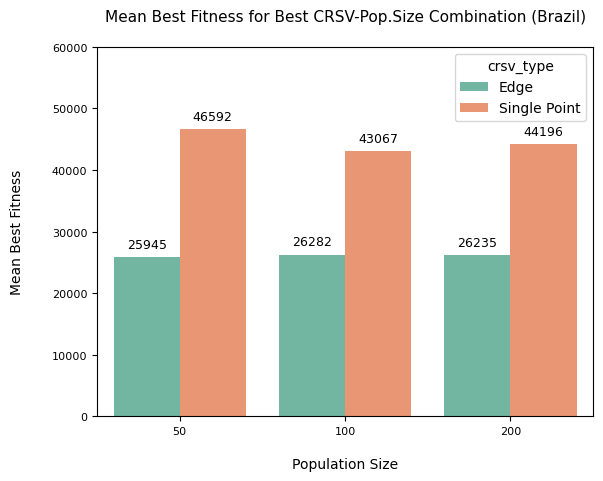

In [44]:
# Define a color palette (you can choose from various palettes)
colors = sns.color_palette("Set2")

ax = sns.barplot(x='pop_size', y='mean_best_fitness', data=min_fit_CRSVpop_BRAZIL, hue='crsv_type', palette=colors)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                size=9,
                xytext=(0, 9),
                textcoords='offset points')
plt.ylim(0,60000)
plt.xlabel('Population Size', labelpad=15)
plt.ylabel('Mean Best Fitness', labelpad=20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# Reduce the font size of the title
plt.title('Mean Best Fitness for Best CRSV-Pop.Size Combination (Brazil)\n', fontsize=11);

# save figure
plt.savefig('figures/BRAZIL_MBF_best_crsv_popsize_comb.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

# Display the plot
plt.show()

Plotting convergence curves of CRSV-Pop size combinations with the best fitness

In [45]:
min_fit_CRSVpop_BRAZIL

,crsv_type,pop_size,tourn_size,mut_type,repl_type,mean_best_fitness,MBF_Marg.Err,mean_exec_time,MET_Marg.Err
11,Edge,50,10,inversion,Weakest,25945.2,372.03,31.73,0.12
43,Edge,100,20,inversion,Weakest,26282.2,405.35,32.86,0.24
67,Edge,200,20,inversion,Weakest,26234.8,354.96,33.29,0.11
79,Single Point,50,5,swap,Weakest,46592.4,4244.71,3.65,0.08
111,Single Point,100,10,swap,Weakest,43066.8,2502.72,3.95,0.02
143,Single Point,200,20,swap,Weakest,44196.5,2535.19,4.71,0.07


In [46]:
plotData_ConvCurv = pd.merge(left=min_fit_CRSVpop_BRAZIL, right=brazil_fit_iter, how='left', on=['crsv_type', 'pop_size', 'tourn_size', 'mut_type','repl_type'])

In [47]:
plotData_ConvCurv.groupby(['crsv_type','pop_size']).count()

tourn_size  mut_type  repl_type  mean_best_fitness  \
crsv_type    pop_size                                                       
Edge         50             10000     10000      10000              10000   
             100            10000     10000      10000              10000   
             200            10000     10000      10000              10000   
Single Point 50             10000     10000      10000              10000   
             100            10000     10000      10000              10000   
             200            10000     10000      10000              10000   

                       MBF_Marg.Err  mean_exec_time  MET_Marg.Err  iteration  \
crsv_type    pop_size                                                          
Edge         50               10000           10000         10000      10000   
             100              10000           10000         10000      10000   
             200              10000           10000         10000      10000   
Single Point 50               10000           10000         10000      10000   
             100              10000           10000         10000      10000   
             200              10000           10000         10000      10000   

                       Mean Best Fitness  Sample SD  ci_low  ci_high  \
crsv_type    pop_size                                                  
Edge         50                    10000      10000   10000    10000   
             100                   10000      10000   10000    10000   
             200                   10000      10000   10000    10000   
Single Point 50                    10000      10000   10000    10000   
             100                   10000      10000   10000    10000   
             200                   10000      10000   10000    10000   

                       Mean Log(Best Fitness)  
crsv_type    pop_size                          
Edge         50                         10000  
             100                        10000  
             200                        10000  
Single Point 50                         10000  
             100                        10000  
             200                        10000

In [48]:
name = ['Edge50', 'Edge100', 'Edge200', 'SngPt50', 'SngPt100', 'SngPt200']

experiment_names = [[i] * 10000 for i in name]
experiment_names = np.reshape(experiment_names, (60000,))

In [49]:
plotData_ConvCurv['Experiment'] = pd.Series(experiment_names)

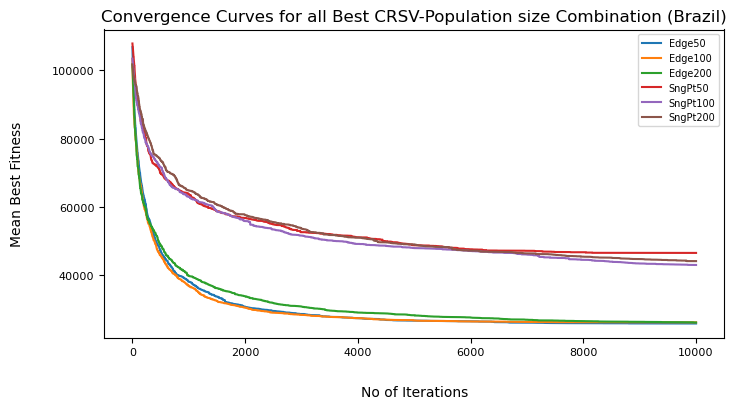

In [50]:
plt.figure(figsize=[8,4])
g = sns.lineplot(x='iteration', y='Mean Best Fitness', data=plotData_ConvCurv,
                 hue='Experiment', palette='tab10')
g.legend(fontsize=7)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel('No of Iterations', labelpad=20)
plt.ylabel('Mean Best Fitness', labelpad=20)
plt.title('Convergence Curves for all Best CRSV-Population size Combination (Brazil)')

# save figure
plt.savefig('figures/BRAZIL_ConvCurv_MBF_best_crsv_popsize_comb.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

# display plot
plt.show()

In [51]:
plotData_ConvCurv.columns

Index(['crsv_type', 'pop_size', 'tourn_size', 'mut_type', 'repl_type',
       'mean_best_fitness', 'MBF_Marg.Err', 'mean_exec_time', 'MET_Marg.Err',
       'iteration', 'Mean Best Fitness', 'Sample SD', 'ci_low', 'ci_high',
       'Mean Log(Best Fitness)', 'Experiment'],
      dtype='object')

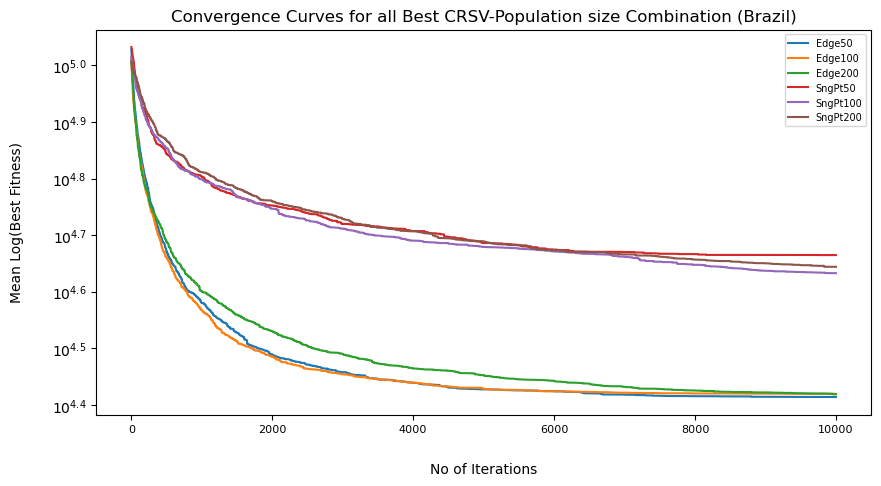

In [52]:
plt.figure(figsize=[10,5])
g = sns.lineplot(x='iteration', y='Mean Log(Best Fitness)', data=plotData_ConvCurv,
                 hue='Experiment', palette='tab10')
g.legend(fontsize=7)
ytick_values = np.arange(4.4,5.1,0.1)
ytick_labels = [fr'$10^{{{x:.1f}}}$' for x in ytick_values]

plt.yticks(ticks=ytick_values, labels=ytick_labels, fontsize=10)
plt.xticks(fontsize=8)
plt.xlabel('No of Iterations', labelpad=20)
plt.ylabel('Mean Log(Best Fitness)', labelpad=20)
plt.title('Convergence Curves for all Best CRSV-Population size Combination (Brazil)')

# save figure
plt.savefig('figures/BRAZIL_ConvCurv_Log_MBF_best_crsv_popsize_comb.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

plt.show()

Show the effect of varying parameters on fitness
* Create df such that rows = pop, tourn and columns = mut_type, repl_type
* Values should be the mean best fitness. But how can I show that the mean is the best? Do divide by the minimumm fitness

In [53]:
min_fitness = brazil_best_comb['mean_best_fitness'].min()
min_fitness

25945.2

In [54]:
max_fitness = brazil_best_comb['mean_best_fitness'].max()
max_fitness

104073.2

In [55]:
plotData_HeatMap = brazil_best_comb[brazil_best_comb['crsv_type'] == 'Single Point']

In [56]:
# Assuming your DataFrame is named df
# You want to pivot based on 'pop_size' and 'tourn_size' columns

# Create a new DataFrame with only relevant columns
pivot_df = plotData_HeatMap[['pop_size', 'tourn_size', 'mut_type', 'repl_type', 'mean_best_fitness']]

# Pivot the DataFrame
pivot_df = pivot_df.pivot(index=['mut_type', 'repl_type'], columns=['pop_size', 'tourn_size'], values='mean_best_fitness')

# Reset the index to have the columns as separate columns
pivot_df = pivot_df.reset_index()

# Optional: Rename the columns to make them more readable
pivot_df.columns.names = (None, None)  # Remove the column names
pivot_df.columns = ['mut_type', 'repl_type'] + [f'pop{pop}_tourn{tourn}' for pop, tourn in pivot_df.columns[2:]]

In [57]:
pivot_df

,mut_type,repl_type,pop50_tourn5,pop50_tourn10,pop50_tourn20,pop100_tourn5,pop100_tourn10,pop100_tourn20,pop200_tourn5,pop200_tourn10,pop200_tourn20
0,insert,1st Weakest,87532.0,90263.2,92364.9,77767.4,80039.6,86118.7,68042.1,76911.9,80841.6
1,insert,Weakest,97937.0,101864.3,103900.7,87571.8,95536.1,96640.3,82419.1,86529.5,92811.8
2,inversion,1st Weakest,86385.8,90389.8,93551.3,80890.6,81566.1,86193.0,69592.1,72541.6,79114.8
3,inversion,Weakest,93926.3,101095.0,104073.2,88206.4,94936.2,98751.4,79430.7,85636.9,93963.7
4,scramble,1st Weakest,70609.4,72999.6,79452.9,64328.3,67067.5,70174.3,64973.9,66383.0,67274.3
5,scramble,Weakest,62057.0,65661.2,70928.6,58450.8,59025.4,62351.6,55123.0,61632.0,62100.3
6,swap,1st Weakest,49496.9,48510.4,50048.5,49601.3,48822.6,46599.5,48401.9,46871.1,47894.6
7,swap,Weakest,46592.4,49987.6,52613.3,45381.3,43066.8,43371.5,46574.6,44750.9,44196.5


Next normalize the data

In [58]:
# Find the range (maximum - minimum)
range_fitness = max_fitness - min_fitness

# Normalize the data by subtracting the minimum and dividing by the range
normalized_data = (pivot_df.iloc[:, 2:] - min_fitness) / range_fitness

# Add the 'mut_type' and 'repl_type' columns back to the normalized data
normalized_data = pd.concat([pivot_df[['mut_type', 'repl_type']], normalized_data], axis=1)

# Set 'mut_type' and 'repl_type' as index
normalized_data.set_index(['mut_type', 'repl_type'], inplace=True)

In [59]:
normalized_data

pop50_tourn5  pop50_tourn10  pop50_tourn20  \
mut_type  repl_type                                                 
insert    1st Weakest      0.788281       0.823239       0.850140   
          Weakest          0.921460       0.971727       0.997792   
inversion 1st Weakest      0.773610       0.824859       0.865325   
          Weakest          0.870125       0.961881       1.000000   
scramble  1st Weakest      0.571680       0.602273       0.684872   
          Weakest          0.462213       0.508345       0.575765   
swap      1st Weakest      0.301450       0.288823       0.308510   
          Weakest          0.264274       0.307731       0.341339   

                       pop100_tourn5  pop100_tourn10  pop100_tourn20  \
mut_type  repl_type                                                    
insert    1st Weakest       0.663299        0.692382        0.770191   
          Weakest           0.788790        0.890729        0.904863   
inversion 1st Weakest       0.703274        0.711920        0.771142   
          Weakest           0.796913        0.883051        0.931884   
scramble  1st Weakest       0.491285        0.526345        0.566111   
          Weakest           0.416056        0.423410        0.465984   
swap      1st Weakest       0.302786        0.292819        0.264365   
          Weakest           0.248773        0.219148        0.223048   

                       pop200_tourn5  pop200_tourn10  pop200_tourn20  
mut_type  repl_type                                                   
insert    1st Weakest       0.538820        0.652349        0.702647  
          Weakest           0.722838        0.775449        0.855860  
inversion 1st Weakest       0.558659        0.596411        0.680545  
          Weakest           0.684588        0.764024        0.870603  
scramble  1st Weakest       0.499548        0.517584        0.528992  
          Weakest           0.373461        0.456773        0.462768  
swap      1st Weakest       0.287435        0.267841        0.280942  
          Weakest           0.264046        0.240704        0.233608

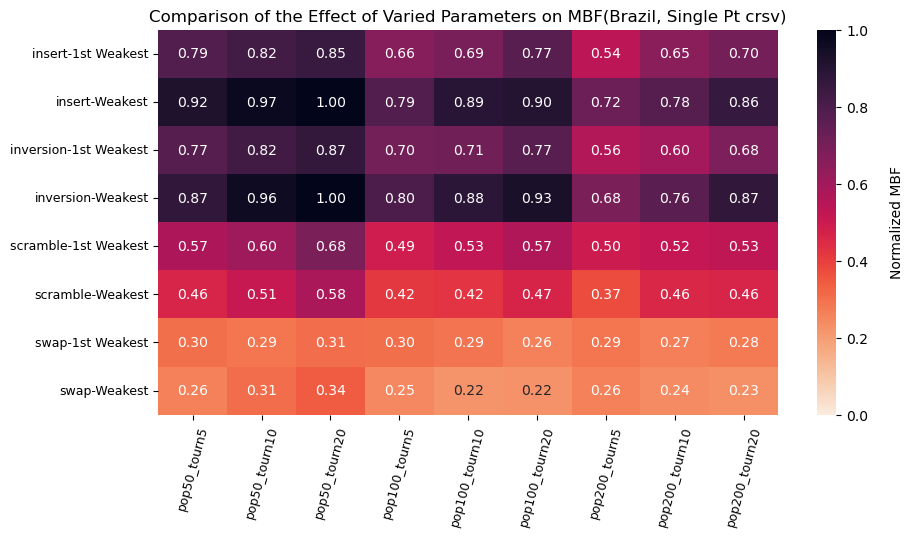

In [60]:
# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(normalized_data, cmap='rocket_r', annot=True, fmt='.2f', linewidths=0, 
            vmin=0, vmax=1, cbar_kws={'label': '\nNormalized MBF'})
plt.title('Comparison of the Effect of Varied Parameters on MBF(Brazil, Single Pt crsv)')
plt.ylabel('')
plt.xticks(rotation=75, fontsize=9)
plt.yticks(fontsize=9)

# save figure
plt.savefig('figures/BRAZIL_HeatMap_varied_param_sptCRSV.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

plt.show()


In [61]:
plotData_HeatMap = brazil_best_comb[brazil_best_comb['crsv_type'] == 'Edge']

In [62]:
# Assuming your DataFrame is named df
# You want to pivot based on 'pop_size' and 'tourn_size' columns

# Create a new DataFrame with only relevant columns
pivot_df = plotData_HeatMap[['pop_size', 'tourn_size', 'mut_type', 'repl_type', 'mean_best_fitness']]

# Pivot the DataFrame
pivot_df = pivot_df.pivot(index=['mut_type', 'repl_type'], columns=['pop_size', 'tourn_size'], values='mean_best_fitness')

# Reset the index to have the columns as separate columns
pivot_df = pivot_df.reset_index()

# Optional: Rename the columns to make them more readable
pivot_df.columns.names = (None, None)  # Remove the column names
pivot_df.columns = ['mut_type', 'repl_type'] + [f'pop{pop}_tourn{tourn}' for pop, tourn in pivot_df.columns[2:]]

# Find the range (maximum - minimum)
range_fitness = max_fitness - min_fitness

# Normalize the data by subtracting the minimum and dividing by the range
normalized_data = (pivot_df.iloc[:, 2:] - min_fitness) / range_fitness

# Add the 'mut_type' and 'repl_type' columns back to the normalized data
normalized_data = pd.concat([pivot_df[['mut_type', 'repl_type']], normalized_data], axis=1)

# Set 'mut_type' and 'repl_type' as index
normalized_data.set_index(['mut_type', 'repl_type'], inplace=True)

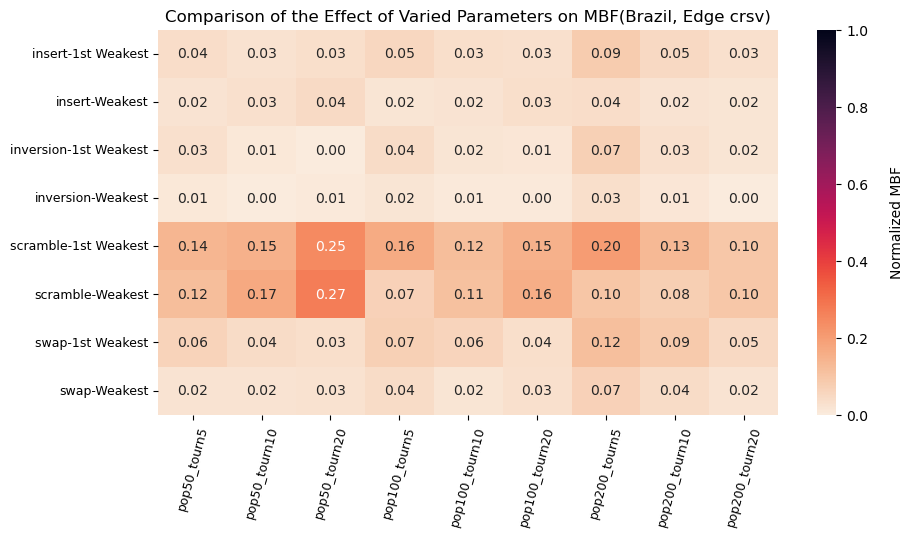

In [63]:
# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(normalized_data, cmap='rocket_r', annot=True, fmt='.2f', linewidths=0, 
            vmin=0, vmax=1, cbar_kws={'label': '\nNormalized MBF'})
plt.title('Comparison of the Effect of Varied Parameters on MBF(Brazil, Edge crsv)')
plt.ylabel('')
plt.xticks(rotation=75, fontsize=9)
plt.yticks(fontsize=9)

# save figure
plt.savefig('figures/BRAZIL_HeatMap_varied_param_edgeCRSV.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

plt.show()

**Working on Burma now**

In [64]:
experiment_dfs_BURMA

,iteration,mut_func,repl_func,37,235,908,72,767,905,715,645,847,960,crsv_type,pop_size,tourn_size
0,0,swap,1st Weakest,5400.0,5415.0,4603.0,4611.0,4767.0,4943.0,4986.0,5099.0,5286.0,5237.0,Single Point,50,5
1,1,swap,1st Weakest,5400.0,5415.0,4603.0,4611.0,4767.0,4943.0,4986.0,5099.0,5286.0,5237.0,Single Point,50,5
2,2,swap,1st Weakest,5400.0,5415.0,4603.0,4611.0,4610.0,4943.0,4986.0,5099.0,5286.0,5237.0,Single Point,50,5
3,3,swap,1st Weakest,5400.0,5415.0,4603.0,4611.0,4610.0,4943.0,4986.0,5099.0,5286.0,5190.0,Single Point,50,5
4,4,swap,1st Weakest,5400.0,5269.0,4603.0,4611.0,4610.0,4943.0,4986.0,5099.0,4954.0,5190.0,Single Point,50,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439995,9995,scramble,Weakest,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,Edge,200,20
1439996,9996,scramble,Weakest,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,Edge,200,20
1439997,9997,scramble,Weakest,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,Edge,200,20
1439998,9998,scramble,Weakest,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,Edge,200,20


In [65]:
# mean best fitness across all trials
experiment_dfs_BURMA['Mean Best Fitness'] = experiment_dfs_BURMA.iloc[:,3:13].mean(axis=1)
experiment_dfs_BURMA['Mean Log(Best Fitness)'] = np.log10(experiment_dfs_BURMA.iloc[:,3:13]).mean(axis=1)
# standard deviation for the fitness
experiment_dfs_BURMA['Sample SD'] = experiment_dfs_BURMA.iloc[:,3:13].std(axis=1,ddof=1)

# let's find the 95% confidence interval for each fitness value
# Calculate the t-value for a 95% confidence interval
t_value = stats.t.ppf(0.975, 10-1)  # 0.975 corresponds to (1 - alpha/2), (10-1) represents the ddof
# calculate the margin of error
marg_err = (t_value * experiment_dfs_BURMA['Sample SD'])/ np.sqrt(10)   # 10 refers to the sample size
# Calculate the lower and upper bounds of the confidence interval   
experiment_dfs_BURMA['ci_low'] = experiment_dfs_BURMA['Mean Best Fitness'] - marg_err 
experiment_dfs_BURMA['ci_high'] = experiment_dfs_BURMA['Mean Best Fitness'] + marg_err 

experiment_dfs_BURMA['Mean Best Fitness'] = experiment_dfs_BURMA['Mean Best Fitness'].round(2)
experiment_dfs_BURMA['Sample SD'] = experiment_dfs_BURMA['Sample SD'].round(2)
experiment_dfs_BURMA['ci_low'] = experiment_dfs_BURMA['ci_low'].round(2)
experiment_dfs_BURMA['ci_high'] = experiment_dfs_BURMA['ci_high'].round(2)

In [66]:
experiment_dfs_BURMA

,iteration,mut_func,repl_func,37,235,908,72,767,905,715,...,847,960,crsv_type,pop_size,tourn_size,Mean Best Fitness,Mean Log(Best Fitness),Sample SD,ci_low,ci_high
0,0,swap,1st Weakest,5400.0,5415.0,4603.0,4611.0,4767.0,4943.0,4986.0,...,5286.0,5237.0,Single Point,50,5,5034.7,3.701251,304.52,4816.86,5252.54
1,1,swap,1st Weakest,5400.0,5415.0,4603.0,4611.0,4767.0,4943.0,4986.0,...,5286.0,5237.0,Single Point,50,5,5034.7,3.701251,304.52,4816.86,5252.54
2,2,swap,1st Weakest,5400.0,5415.0,4603.0,4611.0,4610.0,4943.0,4986.0,...,5286.0,5237.0,Single Point,50,5,5019.0,3.699797,323.33,4787.71,5250.29
3,3,swap,1st Weakest,5400.0,5415.0,4603.0,4611.0,4610.0,4943.0,4986.0,...,5286.0,5190.0,Single Point,50,5,5014.3,3.699405,320.13,4785.29,5243.31
4,4,swap,1st Weakest,5400.0,5269.0,4603.0,4611.0,4610.0,4943.0,4986.0,...,4954.0,5190.0,Single Point,50,5,4966.5,3.695401,285.51,4762.26,5170.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439995,9995,scramble,Weakest,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,...,3323.0,3323.0,Edge,200,20,3323.0,3.521530,0.00,3323.00,3323.00
1439996,9996,scramble,Weakest,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,...,3323.0,3323.0,Edge,200,20,3323.0,3.521530,0.00,3323.00,3323.00
1439997,9997,scramble,Weakest,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,...,3323.0,3323.0,Edge,200,20,3323.0,3.521530,0.00,3323.00,3323.00
1439998,9998,scramble,Weakest,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,3323.0,...,3323.0,3323.0,Edge,200,20,3323.0,3.521530,0.00,3323.00,3323.00


In [67]:
experiment_dfs_BURMA.columns

Index(['iteration', 'mut_func', 'repl_func', '37', '235', '908', '72', '767',
       '905', '715', '645', '847', '960', 'crsv_type', 'pop_size',
       'tourn_size', 'Mean Best Fitness', 'Mean Log(Best Fitness)',
       'Sample SD', 'ci_low', 'ci_high'],
      dtype='object')

In [68]:
burma_fit_iter = experiment_dfs_BURMA[['iteration', 'crsv_type', 'pop_size', 'tourn_size', 'mut_func', 
                                       'repl_func', 'Mean Best Fitness', 'Sample SD', 'ci_low', 'ci_high', 'Mean Log(Best Fitness)']].copy()

In [69]:
burma_fit_iter

,iteration,crsv_type,pop_size,tourn_size,mut_func,repl_func,Mean Best Fitness,Sample SD,ci_low,ci_high,Mean Log(Best Fitness)
0,0,Single Point,50,5,swap,1st Weakest,5034.7,304.52,4816.86,5252.54,3.701251
1,1,Single Point,50,5,swap,1st Weakest,5034.7,304.52,4816.86,5252.54,3.701251
2,2,Single Point,50,5,swap,1st Weakest,5019.0,323.33,4787.71,5250.29,3.699797
3,3,Single Point,50,5,swap,1st Weakest,5014.3,320.13,4785.29,5243.31,3.699405
4,4,Single Point,50,5,swap,1st Weakest,4966.5,285.51,4762.26,5170.74,3.695401
...,...,...,...,...,...,...,...,...,...,...,...
1439995,9995,Edge,200,20,scramble,Weakest,3323.0,0.00,3323.00,3323.00,3.521530
1439996,9996,Edge,200,20,scramble,Weakest,3323.0,0.00,3323.00,3323.00,3.521530
1439997,9997,Edge,200,20,scramble,Weakest,3323.0,0.00,3323.00,3323.00,3.521530
1439998,9998,Edge,200,20,scramble,Weakest,3323.0,0.00,3323.00,3323.00,3.521530


In [70]:
del_pops = [500, 1000]
drop_pop_vals = burma_fit_iter.query("pop_size in @del_pops").index
burma_fit_iter = burma_fit_iter.drop(index=drop_pop_vals)

In [71]:
burma_fit_iter.rename(columns={'mut_func':'mut_type', 'repl_func':'repl_type'}, inplace=True)

In [72]:
best_results_BURMA

,seed,mut_type,repl_type,solution,fitness,exec_time,crsv_type,pop_size,tourn_size,solution_list
0,37,swap,1st Weakest,[10 8 9 12 1 13 2 3 4 5 11 6 0 7],3323.0,2.947004,Single Point,50,5,"[10, 8, 9, 12, 1, 13, 2, 3, 4, 5, 11, 6, 0, 7]"
1,37,swap,Weakest,[ 5 4 11 6 12 8 9 10 7 0 1 2 13 3],3448.0,2.714888,Single Point,50,5,"[5, 4, 11, 6, 12, 8, 9, 10, 7, 0, 1, 2, 13, 3]"
2,37,insert,1st Weakest,[13 2 3 4 6 5 11 8 0 9 10 7 1 12],4159.0,2.145463,Single Point,50,5,"[13, 2, 3, 4, 6, 5, 11, 8, 0, 9, 10, 7, 1, 12]"
3,37,insert,Weakest,[ 3 2 10 7 8 6 1 0 9 12 13 5 4 11],4904.0,2.175828,Single Point,50,5,"[3, 2, 10, 7, 8, 6, 1, 0, 9, 12, 13, 5, 4, 11]"
4,37,inversion,1st Weakest,[ 6 13 2 3 5 4 11 0 8 9 10 7 1 12],4007.0,1.903368,Single Point,50,5,"[6, 13, 2, 3, 5, 4, 11, 0, 8, 9, 10, 7, 1, 12]"
...,...,...,...,...,...,...,...,...,...,...
1435,960,insert,Weakest,[ 8 10 7 12 6 11 5 4 3 2 13 1 0 9],3323.0,7.130688,Edge,200,20,"[8, 10, 7, 12, 6, 11, 5, 4, 3, 2, 13, 1, 0, 9]"
1436,960,inversion,1st Weakest,[ 8 9 0 1 13 2 3 4 5 11 6 12 7 10],3323.0,6.960897,Edge,200,20,"[8, 9, 0, 1, 13, 2, 3, 4, 5, 11, 6, 12, 7, 10]"
1437,960,inversion,Weakest,[11 5 4 3 2 13 1 0 9 8 10 7 12 6],3323.0,6.901158,Edge,200,20,"[11, 5, 4, 3, 2, 13, 1, 0, 9, 8, 10, 7, 12, 6]"
1438,960,scramble,1st Weakest,[ 2 13 1 0 9 8 10 7 12 6 11 5 4 3],3323.0,6.925097,Edge,200,20,"[2, 13, 1, 0, 9, 8, 10, 7, 12, 6, 11, 5, 4, 3]"


Best route for Burma: For this experiment, I got a total of 111 unique solutions all having a minimum fitness of 3323. Here's one of the routes: (10, 8, 9, 12, 1, 13, 2, 3, 4, 5, 11, 6, 0, 7)

In [73]:
best_route_fit = best_results_BURMA['fitness'].min()
del_pops = [500, 1000]

best_route = best_results_BURMA.query("fitness == @best_route_fit")
best_route = best_route.query("pop_size not in @del_pops")
best_route

,seed,mut_type,repl_type,solution,fitness,exec_time,crsv_type,pop_size,tourn_size,solution_list
0,37,swap,1st Weakest,[10 8 9 12 1 13 2 3 4 5 11 6 0 7],3323.0,2.947004,Single Point,50,5,"[10, 8, 9, 12, 1, 13, 2, 3, 4, 5, 11, 6, 0, 7]"
8,235,swap,1st Weakest,[13 2 3 4 5 1 6 12 7 10 8 9 0 11],3323.0,2.858668,Single Point,50,5,"[13, 2, 3, 4, 5, 1, 6, 12, 7, 10, 8, 9, 0, 11]"
17,908,swap,Weakest,[10 7 12 6 11 5 2 3 4 13 1 0 9 8],3323.0,2.684718,Single Point,50,5,"[10, 7, 12, 6, 11, 5, 2, 3, 4, 13, 1, 0, 9, 8]"
24,72,swap,1st Weakest,[ 1 0 9 7 10 8 12 6 11 5 4 3 2 13],3323.0,2.795705,Single Point,50,5,"[1, 0, 9, 7, 10, 8, 12, 6, 11, 5, 4, 3, 2, 13]"
62,645,scramble,1st Weakest,[ 3 2 13 1 10 0 9 8 7 12 6 11 5 4],3323.0,3.023704,Single Point,50,5,"[3, 2, 13, 1, 10, 0, 9, 8, 7, 12, 6, 11, 5, 4]"
...,...,...,...,...,...,...,...,...,...,...
1435,960,insert,Weakest,[ 8 10 7 12 6 11 5 4 3 2 13 1 0 9],3323.0,7.130688,Edge,200,20,"[8, 10, 7, 12, 6, 11, 5, 4, 3, 2, 13, 1, 0, 9]"
1436,960,inversion,1st Weakest,[ 8 9 0 1 13 2 3 4 5 11 6 12 7 10],3323.0,6.960897,Edge,200,20,"[8, 9, 0, 1, 13, 2, 3, 4, 5, 11, 6, 12, 7, 10]"
1437,960,inversion,Weakest,[11 5 4 3 2 13 1 0 9 8 10 7 12 6],3323.0,6.901158,Edge,200,20,"[11, 5, 4, 3, 2, 13, 1, 0, 9, 8, 10, 7, 12, 6]"
1438,960,scramble,1st Weakest,[ 2 13 1 0 9 8 10 7 12 6 11 5 4 3],3323.0,6.925097,Edge,200,20,"[2, 13, 1, 0, 9, 8, 10, 7, 12, 6, 11, 5, 4, 3]"


In [74]:
# Assuming 'solution_list' is the name of the column containing route arrays
best_route['solution_list_tuple'] = best_route['solution_list'].apply(tuple)

# Count the number of unique solutions
num_unique_solutions = best_route['solution_list_tuple'].unique()

# Remove the temporary column
best_route.drop('solution_list_tuple', axis=1, inplace=True)

print(f"Number of unique solutions: {len(num_unique_solutions)}")

Number of unique solutions: 111


In [75]:
num_unique_solutions

array([(10, 8, 9, 12, 1, 13, 2, 3, 4, 5, 11, 6, 0, 7),
       (13, 2, 3, 4, 5, 1, 6, 12, 7, 10, 8, 9, 0, 11),
       (10, 7, 12, 6, 11, 5, 2, 3, 4, 13, 1, 0, 9, 8),
       (1, 0, 9, 7, 10, 8, 12, 6, 11, 5, 4, 3, 2, 13),
       (3, 2, 13, 1, 10, 0, 9, 8, 7, 12, 6, 11, 5, 4),
       (12, 6, 1, 9, 0, 3, 2, 5, 11, 13, 4, 8, 10, 7),
       (7, 10, 8, 9, 0, 1, 13, 2, 3, 4, 5, 11, 6, 12),
       (4, 3, 2, 13, 1, 0, 9, 8, 10, 7, 12, 6, 11, 5),
       (5, 4, 3, 2, 13, 1, 0, 9, 8, 10, 7, 12, 6, 11),
       (1, 13, 2, 3, 4, 5, 11, 6, 12, 7, 10, 8, 9, 0),
       (2, 3, 4, 5, 11, 6, 12, 7, 10, 8, 9, 0, 1, 13),
       (10, 7, 12, 6, 11, 5, 4, 3, 2, 13, 1, 0, 9, 8),
       (10, 8, 9, 0, 1, 13, 2, 3, 4, 5, 11, 6, 12, 7),
       (8, 9, 0, 1, 13, 2, 3, 4, 5, 11, 6, 12, 7, 10),
       (8, 10, 7, 12, 6, 11, 5, 4, 3, 2, 13, 1, 0, 9),
       (5, 11, 6, 12, 7, 10, 8, 9, 0, 1, 13, 2, 3, 4),
       (6, 12, 7, 10, 8, 9, 0, 1, 13, 2, 3, 4, 5, 11),
       (6, 11, 5, 4, 3, 2, 13, 1, 0, 9, 8, 10, 7, 12),
       (3,

In [76]:
best_results_BURMA.columns

Index(['seed', 'mut_type', 'repl_type', 'solution', 'fitness', 'exec_time',
       'crsv_type', 'pop_size', 'tourn_size', 'solution_list'],
      dtype='object')

In [77]:
burma_best_comb = best_results_BURMA.groupby(['crsv_type','pop_size','tourn_size','mut_type','repl_type'])[['fitness', 'exec_time']].mean(numeric_only=True)

In [78]:
best_results_BURMA.groupby(['crsv_type','pop_size','tourn_size','mut_type','repl_type'])[['fitness','seed']].mean(numeric_only=True)

fitness   seed
crsv_type    pop_size tourn_size mut_type  repl_type                  
Edge         50       5          insert    1st Weakest   3323.0  609.1
                                           Weakest       3323.0  609.1
                                 inversion 1st Weakest   3324.3  609.1
                                           Weakest       3324.3  609.1
                                 scramble  1st Weakest   3323.0  609.1
...                                                         ...    ...
Single Point 200      20         inversion Weakest       4274.5  609.1
                                 scramble  1st Weakest   3502.2  609.1
                                           Weakest       3417.2  609.1
                                 swap      1st Weakest   3397.3  609.1
                                           Weakest       3461.5  609.1

[144 rows x 2 columns]

In [79]:
np.mean(seed)

609.1

In [80]:
burma_best_comb

fitness  exec_time
crsv_type    pop_size tourn_size mut_type  repl_type                      
Edge         50       5          insert    1st Weakest   3323.0   5.443789
                                           Weakest       3323.0   5.435913
                                 inversion 1st Weakest   3324.3   5.290872
                                           Weakest       3324.3   5.267345
                                 scramble  1st Weakest   3323.0   5.286356
...                                                         ...        ...
Single Point 200      20         inversion Weakest       4274.5   2.977779
                                 scramble  1st Weakest   3502.2   4.156494
                                           Weakest       3417.2   4.078009
                                 swap      1st Weakest   3397.3   3.828590
                                           Weakest       3461.5   3.778672

[144 rows x 2 columns]

In [81]:
burma_best_comb = burma_best_comb.reset_index()
burma_best_comb

,crsv_type,pop_size,tourn_size,mut_type,repl_type,fitness,exec_time
0,Edge,50,5,insert,1st Weakest,3323.0,5.443789
1,Edge,50,5,insert,Weakest,3323.0,5.435913
2,Edge,50,5,inversion,1st Weakest,3324.3,5.290872
3,Edge,50,5,inversion,Weakest,3324.3,5.267345
4,Edge,50,5,scramble,1st Weakest,3323.0,5.286356
...,...,...,...,...,...,...,...
139,Single Point,200,20,inversion,Weakest,4274.5,2.977779
140,Single Point,200,20,scramble,1st Weakest,3502.2,4.156494
141,Single Point,200,20,scramble,Weakest,3417.2,4.078009
142,Single Point,200,20,swap,1st Weakest,3397.3,3.828590


Now to get the Margin of Error for both fitness and exec_time

In [82]:
# Calculate the t-value for a 95% confidence interval
t_value = stats.t.ppf(0.975, 10-1)  # 0.975 corresponds to (1 - alpha/2), (10-1) represents the ddof

# standard deviation for mean best fitness
burma_res_STD_fit = best_results_BURMA.groupby(['crsv_type','pop_size','tourn_size','mut_type','repl_type'])['fitness'].std(ddof=1,numeric_only=True)
burma_res_MarErr_fit = (t_value * burma_res_STD_fit.values)/ np.sqrt(10)

# standard deviation for mean best fitness
burma_res_STD_time = best_results_BURMA.groupby(['crsv_type','pop_size','tourn_size','mut_type','repl_type'])['exec_time'].std(ddof=1,numeric_only=True)
burma_res_MarErr_time = (t_value * burma_res_STD_time.values)/ np.sqrt(10)


In [83]:
burma_best_comb.columns

Index(['crsv_type', 'pop_size', 'tourn_size', 'mut_type', 'repl_type',
       'fitness', 'exec_time'],
      dtype='object')

In [84]:
burma_best_comb = burma_best_comb.rename(columns={'fitness':'mean_best_fitness', 'exec_time': 'mean_exec_time'})
burma_best_comb['MBF_Marg.Err'] = burma_res_MarErr_fit
burma_best_comb['MET_Marg.Err'] = burma_res_MarErr_time

burma_best_comb = burma_best_comb[['crsv_type', 'pop_size', 'tourn_size', 'mut_type', 'repl_type',
                                   'mean_best_fitness', 'MBF_Marg.Err', 'mean_exec_time', 'MET_Marg.Err']]

In [85]:
burma_best_comb['MBF_Marg.Err'] = burma_best_comb['MBF_Marg.Err'].round(2)
burma_best_comb['mean_exec_time'] = burma_best_comb['mean_exec_time'].round(2)
burma_best_comb['MET_Marg.Err'] = burma_best_comb['MET_Marg.Err'].round(2)

Drop columns with population size 500 and 1000

In [86]:
del_pops = [500, 1000]
drop_pop_vals = burma_best_comb.query("pop_size in @del_pops").index
burma_best_comb = burma_best_comb.drop(index=drop_pop_vals)

In [87]:
burma_best_comb

,crsv_type,pop_size,tourn_size,mut_type,repl_type,mean_best_fitness,MBF_Marg.Err,mean_exec_time,MET_Marg.Err
0,Edge,50,5,insert,1st Weakest,3323.0,0.00,5.44,0.04
1,Edge,50,5,insert,Weakest,3323.0,0.00,5.44,0.03
2,Edge,50,5,inversion,1st Weakest,3324.3,2.94,5.29,0.05
3,Edge,50,5,inversion,Weakest,3324.3,2.94,5.27,0.04
4,Edge,50,5,scramble,1st Weakest,3323.0,0.00,5.29,0.03
...,...,...,...,...,...,...,...,...,...
139,Single Point,200,20,inversion,Weakest,4274.5,165.55,2.98,0.02
140,Single Point,200,20,scramble,1st Weakest,3502.2,119.54,4.16,0.07
141,Single Point,200,20,scramble,Weakest,3417.2,70.24,4.08,0.03
142,Single Point,200,20,swap,1st Weakest,3397.3,88.52,3.83,0.05


In [88]:
burma_best_comb.columns

Index(['crsv_type', 'pop_size', 'tourn_size', 'mut_type', 'repl_type',
       'mean_best_fitness', 'MBF_Marg.Err', 'mean_exec_time', 'MET_Marg.Err'],
      dtype='object')

Now let's get the combination of parameters that let to the best mean best fitness for each **crsv-pop-size combination**

In [89]:
# Group by 'crsv_type' and 'pop_size', and find the index with the minimum 'mean_best_fitness'
min_indices = burma_best_comb.groupby(['crsv_type', 'pop_size'])['mean_best_fitness'].idxmin()

# Use the indices to retrieve the corresponding rows
min_fit_CRSVpop_BURMA = burma_best_comb.loc[min_indices]

print("Rows with Minimum mean_best_fitness:")
min_fit_CRSVpop_BURMA

Rows with Minimum mean_best_fitness:


,crsv_type,pop_size,tourn_size,mut_type,repl_type,mean_best_fitness,MBF_Marg.Err,mean_exec_time,MET_Marg.Err
0,Edge,50,5,insert,1st Weakest,3323.0,0.00,5.44,0.04
24,Edge,100,5,insert,1st Weakest,3323.0,0.00,5.63,0.07
48,Edge,200,5,insert,1st Weakest,3323.0,0.00,5.92,0.06
78,Single Point,50,5,swap,1st Weakest,3355.5,35.28,2.82,0.06
102,Single Point,100,5,swap,1st Weakest,3328.2,4.80,3.00,0.05
124,Single Point,200,5,scramble,1st Weakest,3359.1,50.17,3.54,0.04


Plotting the best Mean Best Fitness values that we have for the population size crossover combinations

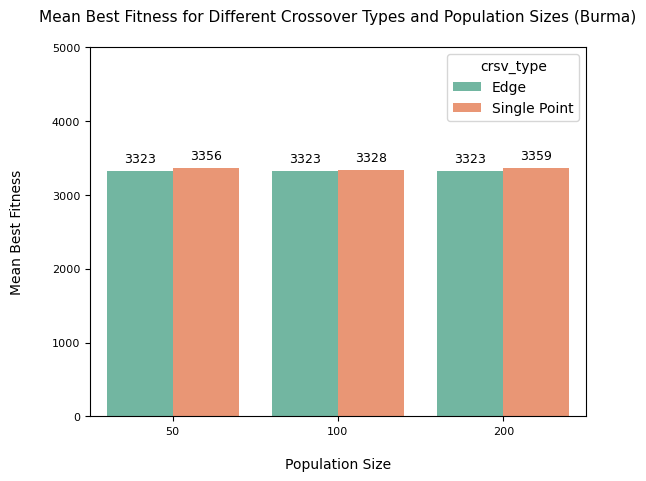

In [90]:
# Define a color palette (you can choose from various palettes)
colors = sns.color_palette("Set2")

ax = sns.barplot(x='pop_size', y='mean_best_fitness', data=min_fit_CRSVpop_BURMA, hue='crsv_type', palette=colors)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                size=9,
                xytext=(0, 9),
                textcoords='offset points')
plt.ylim(0,5000)
plt.xlabel('Population Size', labelpad=15)
plt.ylabel('Mean Best Fitness', labelpad=20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# Reduce the font size of the title
plt.title('Mean Best Fitness for Different Crossover Types and Population Sizes (Burma)\n', fontsize=11)

# save figure
plt.savefig('figures/BURMA_MBF_best_crsv_popsize_comb.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

# Display the plot
plt.show()

Plotting convergence curves of CRSV-Pop size combinations with the best fitness

In [91]:
min_fit_CRSVpop_BURMA

,crsv_type,pop_size,tourn_size,mut_type,repl_type,mean_best_fitness,MBF_Marg.Err,mean_exec_time,MET_Marg.Err
0,Edge,50,5,insert,1st Weakest,3323.0,0.00,5.44,0.04
24,Edge,100,5,insert,1st Weakest,3323.0,0.00,5.63,0.07
48,Edge,200,5,insert,1st Weakest,3323.0,0.00,5.92,0.06
78,Single Point,50,5,swap,1st Weakest,3355.5,35.28,2.82,0.06
102,Single Point,100,5,swap,1st Weakest,3328.2,4.80,3.00,0.05
124,Single Point,200,5,scramble,1st Weakest,3359.1,50.17,3.54,0.04


In [92]:
plotData_ConvCurv = pd.merge(left=min_fit_CRSVpop_BURMA, right=burma_fit_iter, how='left', on=['crsv_type', 'pop_size', 'tourn_size', 'mut_type','repl_type'])

In [93]:
plotData_ConvCurv.groupby(['crsv_type','pop_size']).count()

tourn_size  mut_type  repl_type  mean_best_fitness  \
crsv_type    pop_size                                                       
Edge         50             10000     10000      10000              10000   
             100            10000     10000      10000              10000   
             200            10000     10000      10000              10000   
Single Point 50             10000     10000      10000              10000   
             100            10000     10000      10000              10000   
             200            10000     10000      10000              10000   

                       MBF_Marg.Err  mean_exec_time  MET_Marg.Err  iteration  \
crsv_type    pop_size                                                          
Edge         50               10000           10000         10000      10000   
             100              10000           10000         10000      10000   
             200              10000           10000         10000      10000   
Single Point 50               10000           10000         10000      10000   
             100              10000           10000         10000      10000   
             200              10000           10000         10000      10000   

                       Mean Best Fitness  Sample SD  ci_low  ci_high  \
crsv_type    pop_size                                                  
Edge         50                    10000      10000   10000    10000   
             100                   10000      10000   10000    10000   
             200                   10000      10000   10000    10000   
Single Point 50                    10000      10000   10000    10000   
             100                   10000      10000   10000    10000   
             200                   10000      10000   10000    10000   

                       Mean Log(Best Fitness)  
crsv_type    pop_size                          
Edge         50                         10000  
             100                        10000  
             200                        10000  
Single Point 50                         10000  
             100                        10000  
             200                        10000

In [94]:
name = ['Edge50', 'Edge100', 'Edge200', 'SngPt50', 'SngPt100', 'SngPt200']

experiment_names = [[i] * 10000 for i in name]
experiment_names = np.reshape(experiment_names, (60000,))

In [95]:
plotData_ConvCurv['Experiment'] = pd.Series(experiment_names)

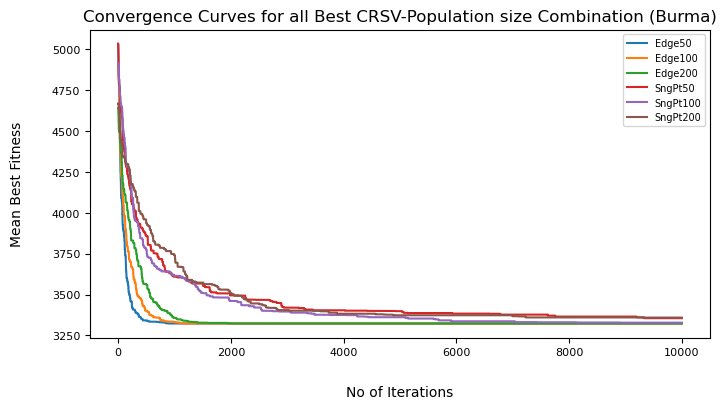

In [96]:
plt.figure(figsize=[8,4])
g = sns.lineplot(x='iteration', y='Mean Best Fitness', data=plotData_ConvCurv,
                 hue='Experiment', palette='tab10')
g.legend(fontsize=7)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel('No of Iterations', labelpad=20)
plt.ylabel('Mean Best Fitness', labelpad=20)
plt.title('Convergence Curves for all Best CRSV-Population size Combination (Burma)')

# save figure
plt.savefig('figures/BURMA_ConvCurv_MBF_best_crsv_popsize_comb.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

plt.show()

In [97]:
plotData_ConvCurv.columns

Index(['crsv_type', 'pop_size', 'tourn_size', 'mut_type', 'repl_type',
       'mean_best_fitness', 'MBF_Marg.Err', 'mean_exec_time', 'MET_Marg.Err',
       'iteration', 'Mean Best Fitness', 'Sample SD', 'ci_low', 'ci_high',
       'Mean Log(Best Fitness)', 'Experiment'],
      dtype='object')

In [98]:
plotData_ConvCurv.query("iteration == 9999")

,crsv_type,pop_size,tourn_size,mut_type,repl_type,mean_best_fitness,MBF_Marg.Err,mean_exec_time,MET_Marg.Err,iteration,Mean Best Fitness,Sample SD,ci_low,ci_high,Mean Log(Best Fitness),Experiment
9999,Edge,50,5,insert,1st Weakest,3323.0,0.00,5.44,0.04,9999,3323.0,0.00,3323.00,3323.00,3.521530,Edge50
19999,Edge,100,5,insert,1st Weakest,3323.0,0.00,5.63,0.07,9999,3323.0,0.00,3323.00,3323.00,3.521530,Edge100
29999,Edge,200,5,insert,1st Weakest,3323.0,0.00,5.92,0.06,9999,3323.0,0.00,3323.00,3323.00,3.521530,Edge200
39999,Single Point,50,5,swap,1st Weakest,3355.5,35.28,2.82,0.06,9999,3355.5,49.32,3320.22,3390.78,3.525716,SngPt50
49999,Single Point,100,5,swap,1st Weakest,3328.2,4.80,3.00,0.05,9999,3328.2,6.71,3323.40,3333.00,3.522209,SngPt100
59999,Single Point,200,5,scramble,1st Weakest,3359.1,50.17,3.54,0.04,9999,3359.1,70.13,3308.93,3409.27,3.526140,SngPt200


In [99]:
best_results_BURMA.mut_type.unique()

array(['swap', 'insert', 'inversion', 'scramble'], dtype=object)

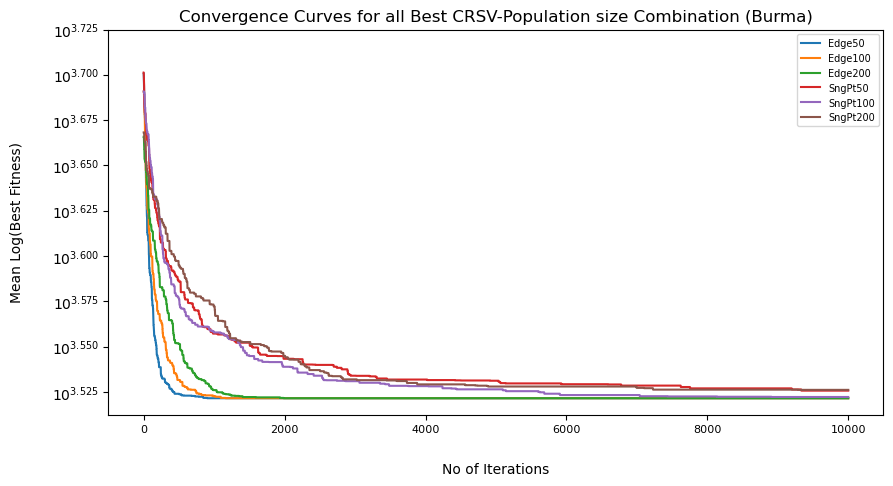

In [100]:
plt.figure(figsize=[10,5])
g = sns.lineplot(x='iteration', y='Mean Log(Best Fitness)', data=plotData_ConvCurv,
                 hue='Experiment', palette='tab10')
g.legend(fontsize=7)
ytick_values = np.arange(3.525,3.725,0.025)
ytick_labels = [fr'$10^{{{x:.3f}}}$' for x in ytick_values]

plt.yticks(ticks=ytick_values, labels=ytick_labels, fontsize=10)
plt.xticks(fontsize=8)
plt.xlabel('No of Iterations', labelpad=20)
plt.ylabel('Mean Log(Best Fitness)', labelpad=20)
plt.title('Convergence Curves for all Best CRSV-Population size Combination (Burma)')

# save figure
plt.savefig('figures/BURMA_ConvCurv_Log_MBF_best_crsv_popsize_comb.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

plt.show()

Show the effect of varying parameters on fitness
* Create df such that rows = pop, tourn and columns = mut_type, repl_type
* Values should be the mean best fitness. But how can I show that the mean is the best? Do divide by the minimumm fitness

In [101]:
min_fitness = burma_best_comb['mean_best_fitness'].min()
min_fitness

3323.0

In [102]:
max_fitness = burma_best_comb['mean_best_fitness'].max()
max_fitness

4902.4

In [103]:
plotData_HeatMap = burma_best_comb[burma_best_comb['crsv_type'] == 'Single Point']

In [104]:
# Assuming your DataFrame is named df
# You want to pivot based on 'pop_size' and 'tourn_size' columns

# Create a new DataFrame with only relevant columns
pivot_df = plotData_HeatMap[['pop_size', 'tourn_size', 'mut_type', 'repl_type', 'mean_best_fitness']]

# Pivot the DataFrame
pivot_df = pivot_df.pivot(index=['mut_type', 'repl_type'], columns=['pop_size', 'tourn_size'], values='mean_best_fitness')

# Reset the index to have the columns as separate columns
pivot_df = pivot_df.reset_index()

# Optional: Rename the columns to make them more readable
pivot_df.columns.names = (None, None)  # Remove the column names
pivot_df.columns = ['mut_type', 'repl_type'] + [f'pop{pop}_tourn{tourn}' for pop, tourn in pivot_df.columns[2:]]

In [105]:
pivot_df

,mut_type,repl_type,pop50_tourn5,pop50_tourn10,pop50_tourn20,pop100_tourn5,pop100_tourn10,pop100_tourn20,pop200_tourn5,pop200_tourn10,pop200_tourn20
0,insert,1st Weakest,4130.8,4294.3,4514.0,3874.8,3763.5,4105.4,3686.2,3767.6,3772.8
1,insert,Weakest,4532.5,4728.0,4902.4,4332.1,4484.6,4763.2,3994.7,4183.2,4357.7
2,inversion,1st Weakest,4179.4,4358.2,4512.2,3863.1,4010.9,4183.8,3608.0,3782.4,3728.3
3,inversion,Weakest,4727.3,4739.6,4819.7,4319.9,4457.6,4728.4,3998.1,4103.0,4274.5
4,scramble,1st Weakest,3481.9,3506.5,3527.4,3433.9,3431.4,3627.6,3359.1,3382.6,3502.2
5,scramble,Weakest,3483.3,3517.7,3590.0,3378.9,3417.0,3562.9,3465.8,3436.9,3417.2
6,swap,1st Weakest,3355.5,3374.2,3459.8,3328.2,3381.7,3363.5,3376.1,3385.8,3397.3
7,swap,Weakest,3562.6,3575.8,3565.7,3417.5,3394.0,3393.4,3380.9,3380.1,3461.5


Next normalize the data

In [106]:
# Find the range (maximum - minimum)
range_fitness = max_fitness - min_fitness

# Normalize the data by subtracting the minimum and dividing by the range
normalized_data = (pivot_df.iloc[:, 2:] - min_fitness) / range_fitness

# Add the 'mut_type' and 'repl_type' columns back to the normalized data
normalized_data = pd.concat([pivot_df[['mut_type', 'repl_type']], normalized_data], axis=1)

# Set 'mut_type' and 'repl_type' as index
normalized_data.set_index(['mut_type', 'repl_type'], inplace=True)

In [107]:
normalized_data

pop50_tourn5  pop50_tourn10  pop50_tourn20  \
mut_type  repl_type                                                 
insert    1st Weakest      0.511460       0.614980       0.754084   
          Weakest          0.765797       0.889578       1.000000   
inversion 1st Weakest      0.542231       0.655439       0.752944   
          Weakest          0.889135       0.896923       0.947638   
scramble  1st Weakest      0.100608       0.116183       0.129416   
          Weakest          0.101494       0.123275       0.169052   
swap      1st Weakest      0.020577       0.032417       0.086615   
          Weakest          0.151703       0.160061       0.153666   

                       pop100_tourn5  pop100_tourn10  pop100_tourn20  \
mut_type  repl_type                                                    
insert    1st Weakest       0.349373        0.278903        0.495378   
          Weakest           0.638914        0.735469        0.911865   
inversion 1st Weakest       0.341965        0.435545        0.545017   
          Weakest           0.631189        0.718374        0.889832   
scramble  1st Weakest       0.070217        0.068634        0.192858   
          Weakest           0.035393        0.059516        0.151893   
swap      1st Weakest       0.003292        0.037166        0.025643   
          Weakest           0.059833        0.044954        0.044574   

                       pop200_tourn5  pop200_tourn10  pop200_tourn20  
mut_type  repl_type                                                   
insert    1st Weakest       0.229961        0.281499        0.284792  
          Weakest           0.425288        0.544637        0.655122  
inversion 1st Weakest       0.180448        0.290870        0.256616  
          Weakest           0.427441        0.493858        0.602444  
scramble  1st Weakest       0.022857        0.037736        0.113461  
          Weakest           0.090414        0.072116        0.059643  
swap      1st Weakest       0.033620        0.039762        0.047043  
          Weakest           0.036659        0.036153        0.087692

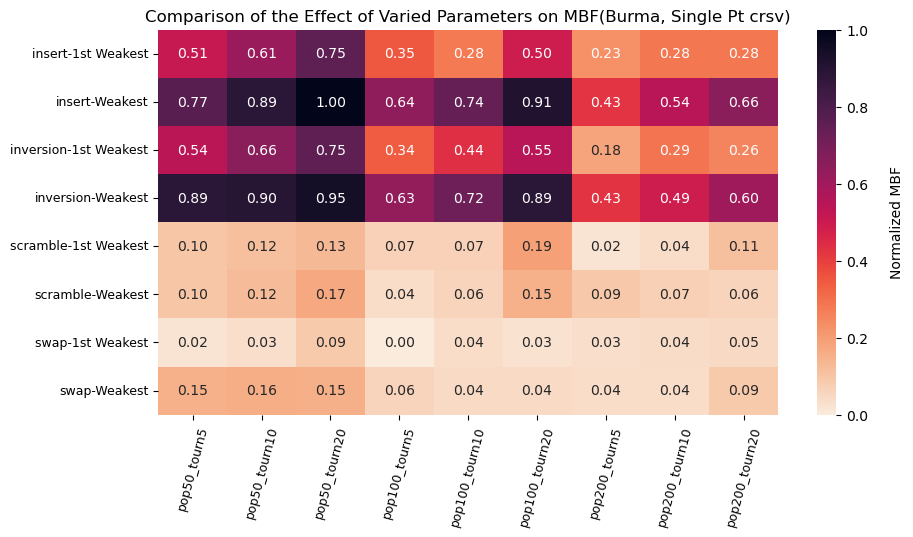

In [108]:
# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(normalized_data, cmap='rocket_r', annot=True, fmt='.2f', linewidths=0, 
            vmin=0, vmax=1, cbar_kws={'label': '\nNormalized MBF'})
plt.title('Comparison of the Effect of Varied Parameters on MBF(Burma, Single Pt crsv)')
plt.ylabel('')
plt.xticks(rotation=75, fontsize=9)
plt.yticks(fontsize=9)

# save figure
plt.savefig('figures/BURMA_HeatMap_varied_param_sptCRSV.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

plt.show()

In [109]:
plotData_HeatMap = burma_best_comb[burma_best_comb['crsv_type'] == 'Edge']

In [110]:
# Assuming your DataFrame is named df
# You want to pivot based on 'pop_size' and 'tourn_size' columns

# Create a new DataFrame with only relevant columns
pivot_df = plotData_HeatMap[['pop_size', 'tourn_size', 'mut_type', 'repl_type', 'mean_best_fitness']]

# Pivot the DataFrame
pivot_df = pivot_df.pivot(index=['mut_type', 'repl_type'], columns=['pop_size', 'tourn_size'], values='mean_best_fitness')

# Reset the index to have the columns as separate columns
pivot_df = pivot_df.reset_index()

# Optional: Rename the columns to make them more readable
pivot_df.columns.names = (None, None)  # Remove the column names
pivot_df.columns = ['mut_type', 'repl_type'] + [f'pop{pop}_tourn{tourn}' for pop, tourn in pivot_df.columns[2:]]

# Find the range (maximum - minimum)
range_fitness = max_fitness - min_fitness

# Normalize the data by subtracting the minimum and dividing by the range
normalized_data = (pivot_df.iloc[:, 2:] - min_fitness) / range_fitness

# Add the 'mut_type' and 'repl_type' columns back to the normalized data
normalized_data = pd.concat([pivot_df[['mut_type', 'repl_type']], normalized_data], axis=1)

# Set 'mut_type' and 'repl_type' as index
normalized_data.set_index(['mut_type', 'repl_type'], inplace=True)

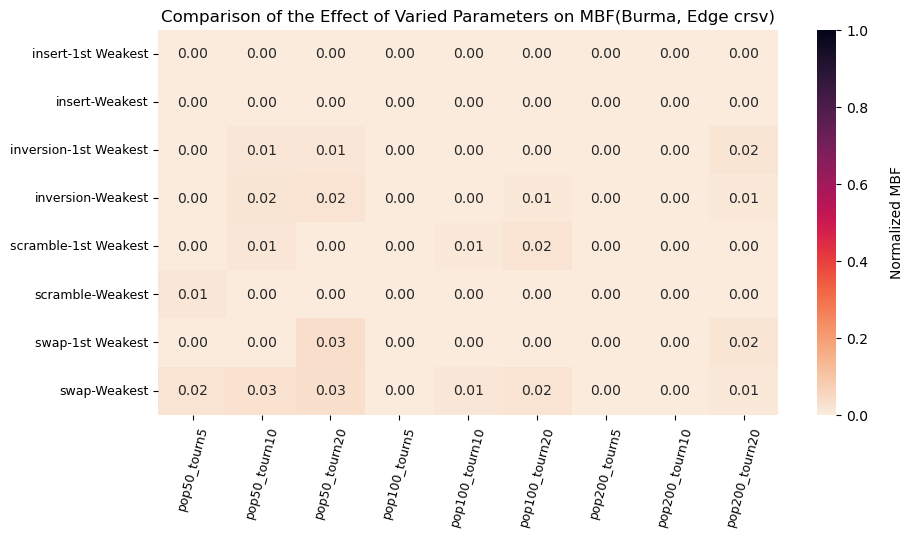

In [111]:
# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(normalized_data, cmap='rocket_r', annot=True, fmt='.2f', linewidths=0, 
            vmin=0, vmax=1, cbar_kws={'label': '\nNormalized MBF'})
plt.title('Comparison of the Effect of Varied Parameters on MBF(Burma, Edge crsv)')
plt.ylabel('')
plt.xticks(rotation=75, fontsize=9)
plt.yticks(fontsize=9)

# save figure
plt.savefig('figures/BURMA_HeatMap_varied_param_edgeCRSV.png', facecolor='white', 
            transparent=False, bbox_inches = "tight")

plt.show()